In [42]:
#The idea of this script is to make a cutflow of the ratio of Run2/Run3 dibosons to figure out where the 
#ratio difference comes from

#External imports
import uproot as ur
import json
import awkward as ak
import numpy as np
import atlas_mpl_style as ampl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
import warnings
import os, sys
from pathlib import Path

#Config
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
os.environ['PATH'] += '/cvmfs/sft.cern.ch/lcg/external/texlive/2020/bin/x86_64-linux'
plt.rc('text', usetex=True)             # Matplotlib LaTeX Compatibility
ampl.use_atlas_style(usetex=True)       # ATLAS Style
#Define paths
sys.path.append(str(Path(os.getcwd()).parent) + '/Scripts/Definers/')
from PathsDefiner import paths_definer
path_pickles = paths_definer()

#Local imports
from AnalysisDefiner import analysis_definer
from AnalysisProcessor import analysis_processor
from LoadFeatures import loadFeatures
from MCMerger import mc_merger
from PaddingRectangularizer import padding_rectangularizer
from PaddingChanger import padding_changer


analysis_base = "24.2.28"
data_sets = ["diboson"]
campaigns = ["MC20a", "MC20d", "MC20e", "MC23a", "MC23c"]

variables = [
    "eventClean",
    "isBadTile",
    "jet_isBadTight",
    "IsMETTrigPassed",
    "jet_n",
    "met",
    "jet_pt",
    "jet_delPhiMet",
    "LeptonVeto",
    "tau_n",
    "ele_n",
    "mu_n",
    "tau_JetRNNMedium",
    "tau_isTruthMatchedTau",
    "tau_truthType",
    "lumiweight",
    "mcEventWeight",
    "pileupweight",
    "beamSpotWeight",
    "jvt_weight",
    "bjet_weight",
    "tau_medium_weight",
    "ele_weight",
    "mu_weight",
]

ar_2 = []
ar_3 = []

for data_set in data_sets:
    for campaign in campaigns:
        print(f"considering {campaign} {data_set}")
        path = f"/disk/atlas3/data_MC/{analysis_base}/PHYS/{campaign}/vector_XEplateau/{data_set}.root"

        with ur.open(path) as temp_file:
            tree = temp_file["NOMINAL"]
            ar = tree.arrays(variables, library="ak")
            ar["weight"] = (
                ar.lumiweight
                * ar.mcEventWeight
                * ar.pileupweight
                * ar.beamSpotWeight
                * ar.jvt_weight
                * ar.bjet_weight
                * ar.tau_medium_weight
                * ar.ele_weight
                * ar.mu_weight
            )

            if campaign.startswith("MC20"):
                ar_2.append(ar)
            elif campaign.startswith("MC23"):
                ar_3.append(ar)
        print(f"finished loading {campaign}")

print("concatenating")
run2 = ak.concatenate(ar_2, axis=0)
print("finished with run2")
run3 = ak.concatenate(ar_3, axis=0)
print("finished with run3")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
considering MC20a diboson
finished loading MC20a
considering MC20d diboson
finished loading MC20d
considering MC20e diboson
finished loading MC20e
considering MC23a diboson
finished loading MC23a
considering MC23c diboson
finished loading MC23c
concatenating
finished with run2
finished with run3


In [53]:
cutflow = {}

cutflow["no_cuts"] = ak.sum(run2.weight) / ak.sum(run3.weight)

run2 = run2[run2.tau_n == 1]
run3 = run3[run3.tau_n == 1]
cutflow["tau_n"] = ak.sum(run2.weight) / ak.sum(run3.weight)

run2 = run2[run2.jet_n >= 2]
run3 = run3[run3.jet_n >= 2]
cutflow["jet_n"] = ak.sum(run2.weight) / ak.sum(run3.weight)

run2 = run2[run2.eventClean != 0]
run3 = run3[run3.eventClean != 0]

run2 = run2[run2.isBadTile == 0]
run3 = run3[run3.isBadTile == 0]

run2 = run2[run2.jet_isBadTight[:,0] != True]
run3 = run3[run3.jet_isBadTight[:,0] != True]

run2 = run2[run2.IsMETTrigPassed != 0]
run3 = run3[run3.IsMETTrigPassed != 0]
cutflow["cleaning"] = ak.sum(run2.weight) / ak.sum(run3.weight)

#run2 = run2[run2.LeptonVeto == 0]
#run3 = run3[run3.LeptonVeto == 0]
#cutflow["LeptonVeto"] = ak.sum(run2.weight) / ak.sum(run3.weight)

#run2 = run2[run2.ele_n == 0]
#run3 = run3[run3.ele_n == 0]
#cutflow["ele_n"] = ak.sum(run2.weight) / ak.sum(run3.weight)

#run2 = run2[run2.mu_n >= 1]
#run3 = run3[run3.mu_n >= 1]
#cutflow["mu_n"] = ak.sum(run2.weight) / ak.sum(run3.weight)

run2 = run2[((run2.mu_n >= 1) & (run2.ele_n <= 1)) | (run2.ele_n == 1)]
run3 = run3[((run3.mu_n >= 1) & (run3.ele_n <= 1)) | (run3.ele_n == 1)]
cutflow["LeptonVeto_v2"] = ak.sum(run2.weight) / ak.sum(run3.weight)

run2 = run2[run2.met / 1000 >= 200]
run3 = run3[run3.met / 1000 >= 200]
cutflow["met"] = ak.sum(run2.weight) / ak.sum(run3.weight)

run2 = run2[run2.jet_pt[:, 0] / 1000 > 120]
run3 = run3[run3.jet_pt[:, 0] / 1000 > 120]
cutflow["jet_pt"] = ak.sum(run2.weight) / ak.sum(run3.weight)

run2 = run2[run2.jet_delPhiMet[:, 0] > 0.4]
run3 = run3[run3.jet_delPhiMet[:, 0] > 0.4]

run2 = run2[run2.jet_delPhiMet[:, 1] > 0.4]
run3 = run3[run3.jet_delPhiMet[:, 1] > 0.4]
cutflow["jet_delPhiMet"] = ak.sum(run2.weight) / ak.sum(run3.weight)

run2 = run2[run2.tau_JetRNNMedium[:, 0] != 0]
run3 = run3[run3.tau_JetRNNMedium[:, 0] != 0]
cutflow["tauJetRNNMedium"] = ak.sum(run2.weight) / ak.sum(run3.weight)

run2 = run2[run2.tau_isTruthMatchedTau[:, 0] == 1]
run3 = run3[run3.tau_isTruthMatchedTau[:, 0] == 1]
cutflow["tau_isTruthMatchedTau"] = ak.sum(run2.weight) / ak.sum(run3.weight)


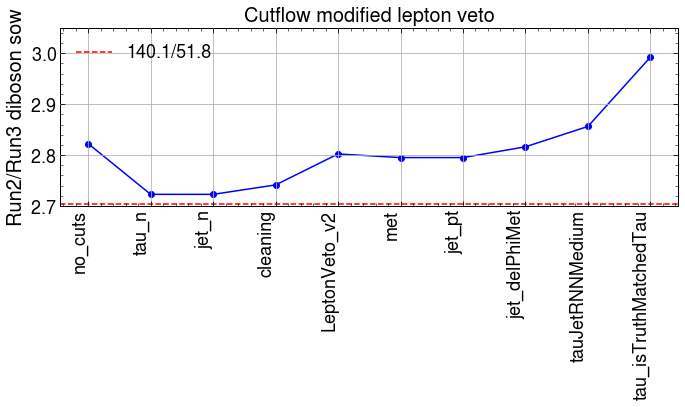

In [54]:
def plot_cutflow(cutflow, savename):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(cutflow.keys(), cutflow.values(), marker='o', linestyle='-', color='b')

    ax.set_ylabel('Run2/Run3 diboson sow')
    ax.set_title('Cutflow modified lepton veto')

    ax.axhline(y=140.1/51.8, color='r', linestyle='--', label='140.1/51.8')

    plt.xticks(rotation=90, ha="right")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.savefig(savename)
    plt.show()
    
plot_cutflow(cutflow, savename = "/home/thillers/TauXAnalysis/plots/misc/cutflow_modified_leptonVeto.pdf")
